In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 414.1827, train_label_loss: 2.7896, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 11659.7035, train_label_loss: 2.6215, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 11648.4982, train_label_loss: 2.7175, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 11724.1813, train_label_loss: 2.2888, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 11785.3023, train_label_loss: 2.1488, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 11786.6104, train_label_loss: 2.0425, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 11744.8616, train_label_loss: 1.8185, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 12107.9106, train_label_loss: 1.7286, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 10700.6633, train_label_loss: 1.7556, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 10615.5580, train_label_loss: 1.4033, 


epoch: 1, source_val_acc_label: 0.5850, source_val_label_loss: 1.2488, target_val_acc_label: 0.5850, target_val_label_loss: 1.2488, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 10.8100, train_label_loss: 1.2683, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 10647.0931, train_label_loss: 1.3039, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 10679.3358, train_label_loss: 1.4369, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 10686.0009, train_label_loss: 1.1441, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 10699.7179, train_label_loss: 1.1252, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 10725.5319, train_label_loss: 1.3871, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 10716.9263, train_label_loss: 0.9894, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 10654.2481, train_label_loss: 1.0142, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 10744.6383, train_label_loss: 0.8917, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 10728.5788, train_label_loss: 1.0228, 


epoch: 2, source_val_acc_label: 0.7041, source_val_label_loss: 0.8602, target_val_acc_label: 0.7041, target_val_label_loss: 0.8602, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 12.8229, train_label_loss: 0.9462, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 11709.1332, train_label_loss: 1.1292, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 11698.6921, train_label_loss: 0.8118, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 11872.1918, train_label_loss: 0.9318, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 11681.8977, train_label_loss: 0.7742, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 11712.0024, train_label_loss: 0.8467, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 11735.5481, train_label_loss: 0.7236, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 11651.4195, train_label_loss: 0.9104, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 12365.1939, train_label_loss: 0.7742, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 10774.3228, train_label_loss: 1.0241, 


epoch: 3, source_val_acc_label: 0.7410, source_val_label_loss: 0.7395, target_val_acc_label: 0.7410, target_val_label_loss: 0.7395, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 11.8688, train_label_loss: 0.6052, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 10543.1800, train_label_loss: 0.7592, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 10731.1313, train_label_loss: 0.5633, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 10683.7896, train_label_loss: 0.8839, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 10697.3487, train_label_loss: 0.5259, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 10691.1619, train_label_loss: 0.5410, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 11163.6045, train_label_loss: 0.8661, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 11624.3063, train_label_loss: 0.6172, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 11703.1389, train_label_loss: 0.6494, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 11754.0227, train_label_loss: 0.4851, 


epoch: 4, source_val_acc_label: 0.7669, source_val_label_loss: 0.6424, target_val_acc_label: 0.7669, target_val_label_loss: 0.6424, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 13.1845, train_label_loss: 0.5002, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 11781.3378, train_label_loss: 0.5544, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 11759.6986, train_label_loss: 0.6334, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 11773.2913, train_label_loss: 0.4132, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 12320.9403, train_label_loss: 0.4474, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 10749.4306, train_label_loss: 0.6442, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 10736.7952, train_label_loss: 0.4397, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 10702.2333, train_label_loss: 0.7186, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 10773.2630, train_label_loss: 0.5084, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 10728.3598, train_label_loss: 0.6577, 


epoch: 5, source_val_acc_label: 0.7633, source_val_label_loss: 0.6440, target_val_acc_label: 0.7633, target_val_label_loss: 0.6440, 


epoch: 6, [batch: 1 / 7000], examples_per_second: 11.5438, train_label_loss: 0.4500, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 10733.4762, train_label_loss: 0.6061, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 10714.8586, train_label_loss: 0.6198, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 10693.7818, train_label_loss: 0.7088, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 10763.0771, train_label_loss: 0.5085, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 10731.8463, train_label_loss: 0.6198, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 10702.6304, train_label_loss: 0.6601, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 10718.6768, train_label_loss: 0.3654, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 11653.8027, train_label_loss: 0.3696, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 11771.9596, train_label_loss: 0.6381, 


epoch: 6, source_val_acc_label: 0.7667, source_val_label_loss: 0.6363, target_val_acc_label: 0.7667, target_val_label_loss: 0.6363, 


epoch: 7, [batch: 1 / 7000], examples_per_second: 13.2220, train_label_loss: 0.6749, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 11751.0769, train_label_loss: 0.6598, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 11797.4683, train_label_loss: 0.3996, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 11797.2605, train_label_loss: 0.4585, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 11835.6969, train_label_loss: 0.4241, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 11811.3118, train_label_loss: 0.3305, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 12138.7369, train_label_loss: 0.4602, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 10725.5080, train_label_loss: 0.4235, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 10726.3441, train_label_loss: 0.7367, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 10740.9014, train_label_loss: 0.3525, 


epoch: 7, source_val_acc_label: 0.7454, source_val_label_loss: 0.7039, target_val_acc_label: 0.7454, target_val_label_loss: 0.7039, 


epoch: 8, [batch: 1 / 7000], examples_per_second: 11.7446, train_label_loss: 0.3298, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 10700.4434, train_label_loss: 0.4667, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10705.0681, train_label_loss: 0.2647, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10744.4958, train_label_loss: 0.5064, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 11589.0977, train_label_loss: 0.3720, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 11763.9050, train_label_loss: 0.4048, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 11764.5719, train_label_loss: 0.2832, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 11764.3642, train_label_loss: 0.5382, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 11812.3172, train_label_loss: 0.4299, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 11764.3837, train_label_loss: 0.4115, 


epoch: 8, source_val_acc_label: 0.7778, source_val_label_loss: 0.6200, target_val_acc_label: 0.7778, target_val_label_loss: 0.6200, 


New best
epoch: 9, [batch: 1 / 7000], examples_per_second: 13.2521, train_label_loss: 0.2711, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 11775.5371, train_label_loss: 0.2485, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 11892.2415, train_label_loss: 0.2477, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 10708.9914, train_label_loss: 0.2767, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 10724.3254, train_label_loss: 0.5701, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 10667.6766, train_label_loss: 0.5301, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 10715.1091, train_label_loss: 0.2411, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 10711.0614, train_label_loss: 0.4150, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 10707.6019, train_label_loss: 0.7703, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 10701.9648, train_label_loss: 0.4533, 


epoch: 9, source_val_acc_label: 0.7876, source_val_label_loss: 0.5953, target_val_acc_label: 0.7876, target_val_label_loss: 0.5953, 


New best
epoch: 10, [batch: 1 / 7000], examples_per_second: 11.6821, train_label_loss: 0.2215, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 10662.6491, train_label_loss: 0.2355, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 10761.5595, train_label_loss: 0.3587, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10687.1359, train_label_loss: 0.3274, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 10669.4396, train_label_loss: 0.3212, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 10659.3679, train_label_loss: 0.2510, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 11665.2550, train_label_loss: 0.2715, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 11752.4634, train_label_loss: 0.7171, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 11743.4651, train_label_loss: 0.3509, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 11758.3383, train_label_loss: 0.4225, 


epoch: 10, source_val_acc_label: 0.7861, source_val_label_loss: 0.6011, target_val_acc_label: 0.7861, target_val_label_loss: 0.6011, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 13.1801, train_label_loss: 0.2407, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 11772.0135, train_label_loss: 0.2311, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 11782.6024, train_label_loss: 0.2887, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 11712.2970, train_label_loss: 0.2157, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 12061.4598, train_label_loss: 0.3983, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 10688.4553, train_label_loss: 0.2356, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 10677.4546, train_label_loss: 0.2072, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 10659.3452, train_label_loss: 0.3234, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 10672.7057, train_label_loss: 0.3808, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 10680.5865, train_label_loss: 0.3171, 


epoch: 11, source_val_acc_label: 0.7887, source_val_label_loss: 0.6029, target_val_acc_label: 0.7887, target_val_label_loss: 0.6029, 


New best
epoch: 12, [batch: 1 / 7000], examples_per_second: 11.4514, train_label_loss: 0.1726, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 10735.0995, train_label_loss: 0.2481, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 11752.0779, train_label_loss: 0.2202, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 11701.9924, train_label_loss: 0.1486, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 11761.9941, train_label_loss: 0.2457, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 11742.3343, train_label_loss: 0.2188, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 11804.0901, train_label_loss: 0.4396, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 11710.8659, train_label_loss: 0.2611, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 11716.8228, train_label_loss: 0.3447, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 11689.3080, train_label_loss: 0.3815, 


epoch: 12, source_val_acc_label: 0.7817, source_val_label_loss: 0.6309, target_val_acc_label: 0.7817, target_val_label_loss: 0.6309, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 13.1527, train_label_loss: 0.1874, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 11722.1858, train_label_loss: 0.1488, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 11720.1348, train_label_loss: 0.2635, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 11702.4034, train_label_loss: 0.2924, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 11827.3084, train_label_loss: 0.3053, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 11702.4297, train_label_loss: 0.1688, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 11702.4566, train_label_loss: 0.3154, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 11706.1533, train_label_loss: 0.3054, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 11712.5123, train_label_loss: 0.1773, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 11777.6543, train_label_loss: 0.2729, 


epoch: 13, source_val_acc_label: 0.7851, source_val_label_loss: 0.6236, target_val_acc_label: 0.7851, target_val_label_loss: 0.6236, 


epoch: 14, [batch: 1 / 7000], examples_per_second: 13.0984, train_label_loss: 0.1436, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 11692.6542, train_label_loss: 0.2628, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 11769.4792, train_label_loss: 0.2364, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 11712.9748, train_label_loss: 0.1280, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 12652.8309, train_label_loss: 0.2404, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 13021.8806, train_label_loss: 0.2554, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 12914.0149, train_label_loss: 0.2189, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 13173.5229, train_label_loss: 0.2947, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 12958.3534, train_label_loss: 0.2233, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 13085.0697, train_label_loss: 0.1832, 


epoch: 14, source_val_acc_label: 0.7844, source_val_label_loss: 0.6478, target_val_acc_label: 0.7844, target_val_label_loss: 0.6478, 


epoch: 15, [batch: 1 / 7000], examples_per_second: 14.8556, train_label_loss: 0.1905, 


epoch: 15, [batch: 700 / 7000], examples_per_second: 12975.4359, train_label_loss: 0.4332, 


epoch: 15, [batch: 1400 / 7000], examples_per_second: 13734.6029, train_label_loss: 0.2150, 


epoch: 15, [batch: 2100 / 7000], examples_per_second: 11757.9127, train_label_loss: 0.2706, 


epoch: 15, [batch: 2800 / 7000], examples_per_second: 11728.9568, train_label_loss: 0.1454, 


epoch: 15, [batch: 3500 / 7000], examples_per_second: 11680.5858, train_label_loss: 0.1729, 


epoch: 15, [batch: 4200 / 7000], examples_per_second: 11671.0803, train_label_loss: 0.1724, 


epoch: 15, [batch: 4900 / 7000], examples_per_second: 11640.0434, train_label_loss: 0.2333, 


epoch: 15, [batch: 5600 / 7000], examples_per_second: 11661.0953, train_label_loss: 0.2173, 


epoch: 15, [batch: 6300 / 7000], examples_per_second: 11684.8459, train_label_loss: 0.3101, 


epoch: 15, source_val_acc_label: 0.7613, source_val_label_loss: 0.7540, target_val_acc_label: 0.7613, target_val_label_loss: 0.7540, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

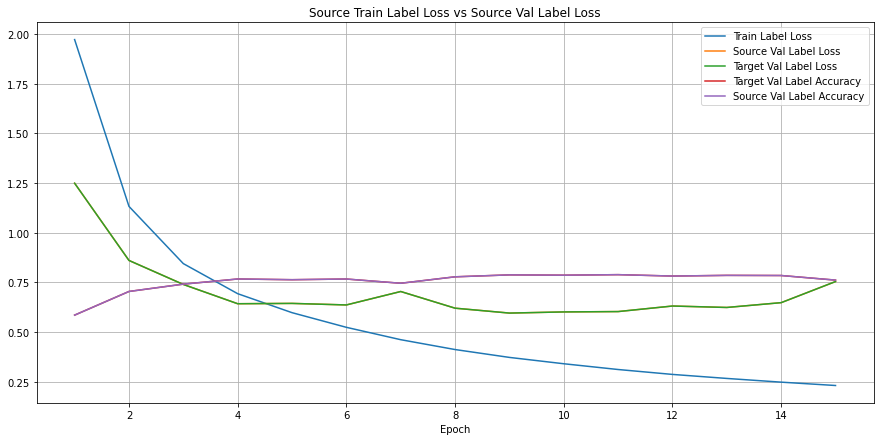

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

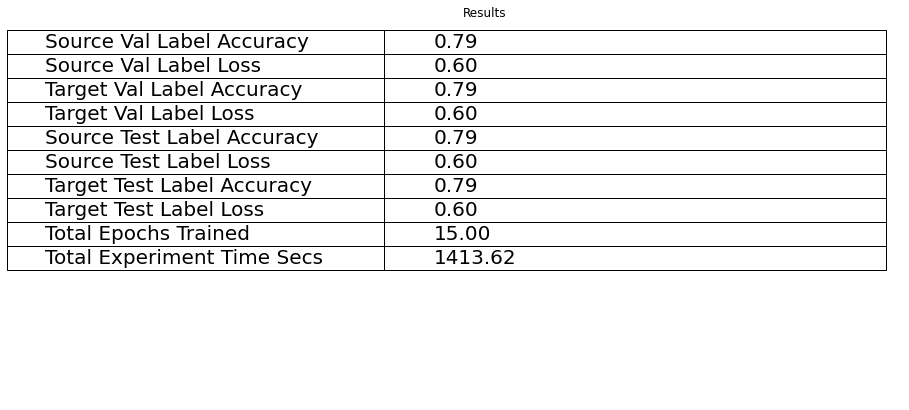

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

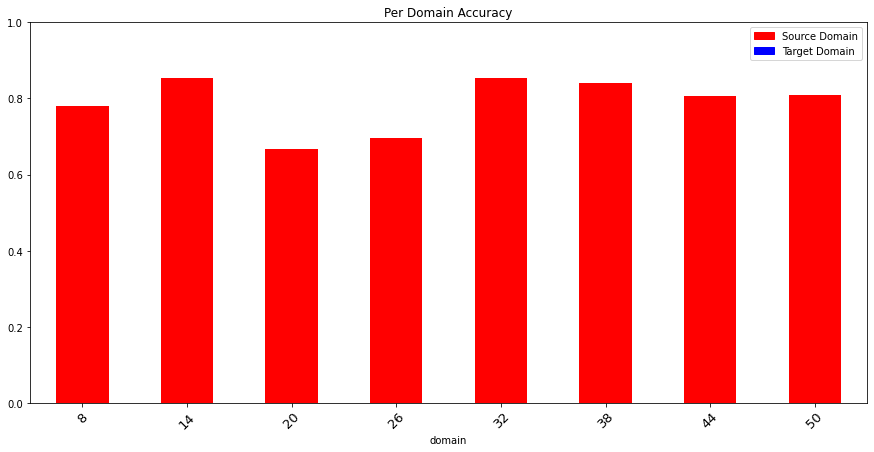

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.787765625 Target Test Label Accuracy: 0.787765625
Source Val Label Accuracy: 0.78871875 Target Val Label Accuracy: 0.78871875


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2", "parameters": {"experiment_name": "cnn_2:oracle.run2", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [